In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
# from pathlib import Path
import glob
from skimage.transform import rotate
np.set_printoptions(precision=2)
# from mpl_toolkits.basemap import Basemap

coords = {'vollsmose':{'left_edge_lng': 10.386036, 
                       'bottom_edge_lat': 55.400343, 
                       'right_edge_lng': 10.457705, 
                       'top_edge_lat': 55.419517},
          'bylderup':{'lllon': 8.86837, 'lllat': 54.889246, 'urlon': 9.445496, 'urlat': 55.065394}
}

bg_imgs = {'vollsmose': "/Users/dirkhovy/Dropbox/working/lowlands/sociolinguistics/chat-on-a-map/data/originals/Oversigtskort_Vollsmose_2.PNG",
           'bylderup': "/Users/dirkhovy/working/lowlands/sociolinguistics/chat-on-a-map/data/originals/Oversigtskort_Bylderup.PNG"
#            'bylderup': '/Users/dirkhovy/Dropbox/working/lowlands/sociolinguistics/chat-on-a-map/data/bylderup_OSM.png',
#            'vollsmose':'/Users/dirkhovy/Dropbox/working/lowlands/sociolinguistics/chat-on-a-map/data/vollsmose_OSM.png'
           }


In [229]:
annotation_dir = "../data/annotations/"

In [230]:
list(glob.glob(annotation_dir + "*"))

['../data/annotations/V_AFA_AOF.png',
 '../data/annotations/V_AFA_FA.png',
 '../data/annotations/V_AFA_FP.png',
 '../data/annotations/V_AFA_HA.png',
 '../data/annotations/V_AFA_TP.png',
 '../data/annotations/V_NKI_AOF.png',
 '../data/annotations/V_NKI_basemap.png',
 '../data/annotations/V_NKI_FA.png',
 '../data/annotations/V_NKI_FP.png',
 '../data/annotations/V_NKI_HA.png']

In [231]:
image_file = annotation_dir + "V_AFA_FA.png"
image_data = plt.imread(str(image_file))

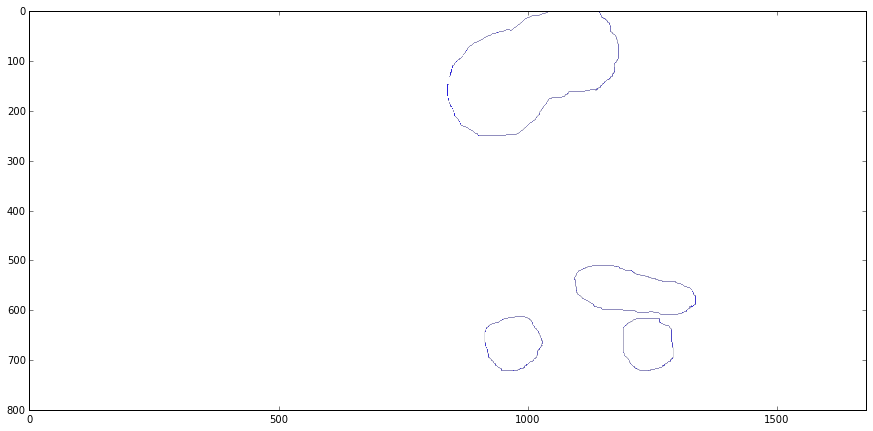

In [232]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(image_data)

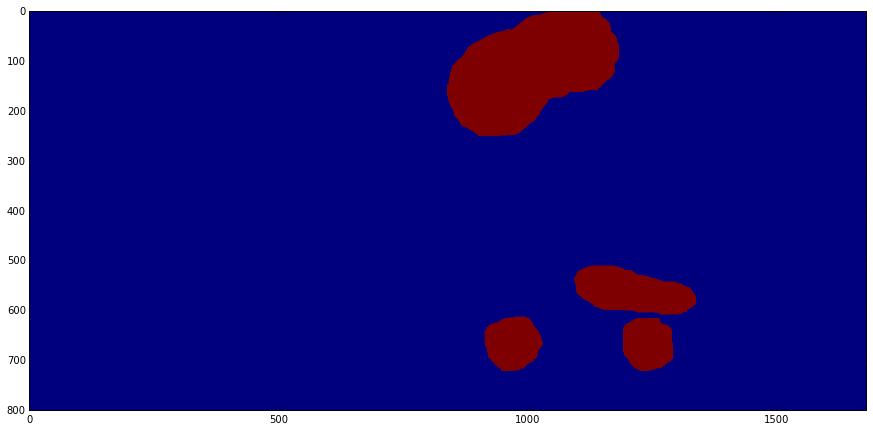

In [233]:
from skimage import color, measure
from scipy import ndimage
from skimage.morphology import binary_erosion, binary_dilation, convex_hull_image, convex_hull_object
fig, ax = plt.subplots(figsize=(15,15))



gimg = color.colorconv.rgb2grey(image_data)
bwimg = gimg > 0
bwimg = binary_dilation(bwimg, None)
bwimg = ndimage.binary_fill_holes(bwimg)
bwimg = binary_erosion(bwimg)
#bwimg = convex_hull_object(bwimg)

#plt.imshow(bwimg[:300, 600:1200])
plt.imshow(bwimg)
#co
contours = measure.find_contours(bwimg, 0.5)


4
X: 837.5 -- 1181.5
Y: 0.5 -- 251.5

X: 1091.5 -- 1335.5
Y: 510.5 -- 608.5

X: 912.5 -- 1028.5
Y: 612.5 -- 721.5

X: 1189.5 -- 1290.5
Y: 615.5 -- 721.5



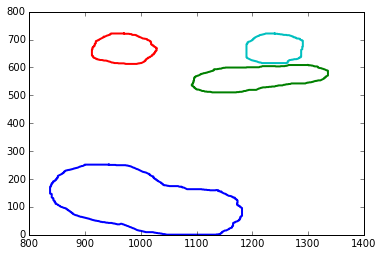

In [234]:
print len(contours)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    print 'X: %s -- %s' % (contour[:,1].min(), contour[:,1].max())
    print 'Y: %s -- %s' % (contour[:,0].min(), contour[:,0].max())
    print

(85, 2)
(0.5, 251.5, 837.5, 1181.5)


(-100, 800)

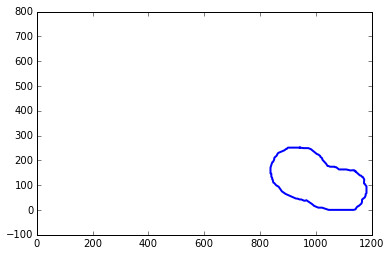

In [235]:
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
new_s = contours[0].copy()
appr_s = approximate_polygon(new_s, 0.9)
print(appr_s.shape)
print(appr_s[:,0].min(), appr_s[:,0].max(), appr_s[:,1].min(), appr_s[:,1].max())
rotated = np.abs(appr_s)
fig, ax = plt.subplots()
ax.plot(appr_s[:, 1], appr_s[:, 0], linewidth=2)
ax.plot(rotated[:, 0], rotated[:, 1], linewidth=2)
ax.set_ylim(-100, 800)

## Convert from pixel coordinates to geo coordinates

```
lng = left_edge_lng + pixel_x * (right_edge_lng - left_edge_lng) 
lat = top_edge_lat - pixel_y * (top_edge_lat - bottom_edge_lat)
```


(800, 1679)
[ 251.5  251.5  246.5  246.5  240.5  230.5  228.   219.   211.   203. ]
10.386036 10.457705 55.419517 55.400343
[ 1427.5  1427.5  1432.5  1432.5  1438.5  1448.5  1451.   1460.   1468.
  1476. ]
[ 943.   900.   896.   894.   887.   866.   863.5  859.5  851.5  850.5]
[[  1.   0.]
 [  1.   7.]
 [  1.  10.]]


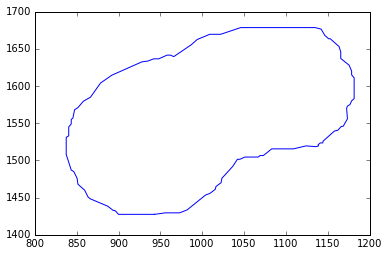

In [236]:
def convert_to_lat_lng(xy, left_edge_lng, right_edge_lng, top_edge_lat, bottom_edge_lat, map_shape):
    geo = np.zeros_like(xy)
    print xy[:10,0]
    print left_edge_lng, right_edge_lng, top_edge_lat, bottom_edge_lat
    dist_lng = (left_edge_lng - right_edge_lng)
    geo[:, 0] = left_edge_lng - (xy[:, 1] / map_shape[0]) * dist_lng
    dist_lat = (top_edge_lat - bottom_edge_lat)
    geo[:, 1] = top_edge_lat - (xy[:, 0] / map_shape[1]) * dist_lat
    return geo


print bwimg.shape
geo = convert_to_lat_lng(appr_s, map_shape=bwimg.shape, **coords['vollsmose'])
geo = convert_to_inverse(appr_s, bwimg.shape)
print geo[:10,0]
print geo[:10,1]
plt.plot(geo[:, 1], geo[:, 0])

print convert_to_inverse(np.array([[1,0],[1,7],[1,10]]), (10,2))

In [263]:
def get_contour(image):
    image_data = plt.imread(image)

    gimg = color.colorconv.rgb2grey(image_data)
    bwimg = gimg > 0
    # make sure it's closed
    bwimg = binary_dilation(bwimg, None)
    bwimg = ndimage.binary_fill_holes(bwimg)
    # shrink it
    bwimg = binary_erosion(bwimg)
    
    contours = [approximate_polygon(new_s, 0.9) for new_s in measure.find_contours(bwimg, 0.5)]

    return bwimg, contours



install pryproj: conda install -c https://conda.binstar.org/jjhelmus pyproj

(800, 1679, 4)
Map size: 7964 width, 3753 height
Scaling factors: x=4.6916, y=4.7435
5.93934475137e-05
1.72644586111e-05
9.94891248404e-06
9.21500541327e-06
0.000201154941018


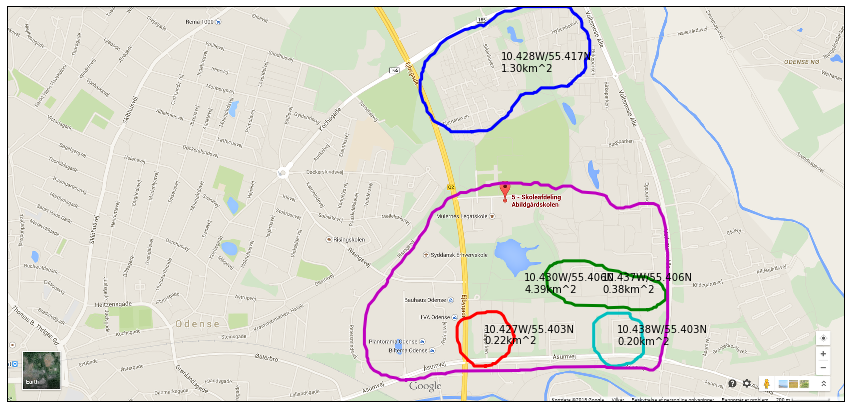

In [290]:
town = 'vollsmose'

fig, ax = plt.subplots(figsize=(15,15))

m = Basemap(llcrnrlon=coords[town]['left_edge_lng'],
            llcrnrlat=coords[town]['bottom_edge_lat'],
            urcrnrlon=coords[town]['right_edge_lng'],
            urcrnrlat=coords[town]['top_edge_lat'],
            lat_ts=2, resolution='l', projection='merc',
            lon_0=(coords[town]['right_edge_lng'] + coords[town]['left_edge_lng']) / 2.0,
            lat_0=(coords[town]['top_edge_lat'] + coords[town]['bottom_edge_lat']) / 2.0)

# load the appropriate background image
background = plt.imread(bg_imgs[town])
m.imshow(background, interpolation='lanczos', origin='upper')
map_width, map_height = m(coords[town]['right_edge_lng'], coords[town]['top_edge_lat'])
x_factor = map_height / background.shape[0]
y_factor = map_width / background.shape[1]
print background.shape
print "Map size: %d width, %d height" % (map_width, map_height)
print "Scaling factors: x=%.4f, y=%.4f" % (x_factor, y_factor)

from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform
from functools import partial
import pyproj

# projection calculator
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj('+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +no_defs'))


for file_name in ['/Users/dirkhovy/Dropbox/working/lowlands/sociolinguistics/chat-on-a-map/data/annotations/V_AFA_FA.png',
                '/Users/dirkhovy/Dropbox/working/lowlands/sociolinguistics/chat-on-a-map/data/annotations/V_NKI_FA.png'
                 ]:
    b2, im2 = get_contour(file_name)

    for c, contour in enumerate(im2):        
        # scale up dimensions to map size
        x, y = contour[:, 1] * x_factor, contour[:, 0] * y_factor
        
        # invert the y-axis
        y = np.abs(y - map_height)

        m.plot(x, y, linewidth=3)
        
        # convert to coordinates
        lng, lat = m(x, y, inverse=True)
        # cast as Polygon
        poly = Polygon(zip(lng, lat))
        #get center
        center = poly.centroid
        center_x, center_y = center.coords[0]
        xpt, ypt = m(center_x, center_y)
                
        poly_g = transform(project, poly)
        # compute area
        print  poly.area
        km2 = poly_g.area / 1000000.0
        plt.text(xpt, ypt-50, '%.3fW/%.3fN\n%.2fkm^2' % (center_x, center_y, km2))

